Method : PC


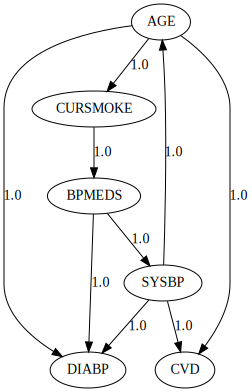

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
Expectation(Derivative(CVD, [SYSBP])*Derivative([SYSBP], [BPMEDS]))
Estimand assumption 1, Full-mediation: SYSBP intercepts (blocks) all directed paths from BPMEDS to C,V,D.
Estimand assumption 2, First-stage-unconfoundedness: If U→{BPMEDS} and U→{SYSBP} then P(SYSBP|BPMEDS,U) = P(SYSBP|BPMEDS)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{SYSBP} and U→CVD then P(CVD|SYSBP, BPMEDS, U) = P(CVD|SYSBP, BPMEDS)

Intercept = 0.236
Parameter 1 = 0.157
E(Y|A = 1) = 0.393
E(Y|A = 0) = 0.236
Risk Ratio = 1.662
Risk Difference = 0.157
95% risk difference confidence interval = [0.12 0.19]
95% risk ratio confidence interval = [1.49  1.858]


In [21]:
import dowhy
# from IPython.core.display_functions import display
from IPython.core.display import display
from dowhy import CausalModel
# from rpy2.robjects import r as R
# %load_ext rpy2.ipython
import numpy as np
import pandas as pd
import graphviz
import networkx as nx


# Q3.3 Most of the causal discovery codes are referenced from here https://github.com/microsoft/dowhy/blob/master/docs/source/example_notebooks/dowhy_causal_discovery_example.ipynb, other codes are similar to our own estimation

# That's just a utility function to connect each node and add label
def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for name in names:
        d.node(name)
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=str(coef))
    return d


# read mean dataset
df = pd.read_csv("../data/data_mean.csv")
# We simply drop those subject who have missing data
df = df.dropna()

import cdt
from cdt.causality.graph import LiNGAM, PC, GES
import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
# Change to your Rscript path
cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.1.3/bin/Rscript'
graphs = {}
labels = [f'{col}' for i, col in enumerate(df.columns)]
# The algorithm we use. We only use PC algorithm since we don't have time to explore other algorithms
functions = {
    'PC': PC
}

# For each algorithm, the predict method create the graph using that algorithm
for method, lib in functions.items():
    obj = lib()
    output = obj.predict(df)
    adj_matrix = nx.to_numpy_matrix(output)
    adj_matrix = np.asarray(adj_matrix)
    graph_dot = make_graph(adj_matrix, labels)
    graphs[method] = graph_dot

# Visualize graphs
for method, graph in graphs.items():
    print("Method : %s" % method)
    display(graph)
    # Define Causal Model, the graph is just the graph we create using PC algorithm above. Don't really understand what the label mean, but that's what CDT returns
    model = CausalModel(
        data=df,
        treatment='BPMEDS',
        outcome='CVD',
        graph="digraph {"
              "SYSBP -> AGE [label=1.0];"
              "BPMEDS -> SYSBP [label=1.0];"
              "AGE -> DIABP [label=1.0];"
              "SYSBP -> DIABP [label=1.0];"
              "BPMEDS -> DIABP [label=1.0];"
              "AGE -> CURSMOKE [label=1.0];"
              "CURSMOKE -> BPMEDS [label=1.0];"
              "AGE -> CVD [label=1.0];"
              "SYSBP -> CVD [label=1.0];"
              "}"
    )
    # Figure out which estimators to using Dowhy
    # Q3.3 we can only estimate this dataset
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    print(identified_estimand)
    # We use frontdoor since the that's the only available method for this graph
    estimate = model.estimate_effect(identified_estimand, method_name="frontdoor.linear_regression")
    for i, v in enumerate(model.causal_estimator.model.params):
        if i == 0:
            print("Intercept =", "{:.3f}".format(v))
        else:
            print("Parameter %s =" % str(i), "{:.3f}".format(v))
    # Q2.3 Q3.1 Calculate E(Y|A = 1) and E(Y|A = 0) and risk ratio, since estimate_effect only gives us risk difference
    E1 = model.do(1, identified_estimand, method_name="frontdoor.linear_regression")
    E0 = model.do(0, identified_estimand, method_name="frontdoor.linear_regression")
    # Calculate 95% percent confidence interval
    difference_bootstrap = model.causal_estimator.estimate_confidence_intervals(estimate.value, confidence_level=0.95,
                                                                                method="bootstrap")
    print("E(Y|A = 1) =", "{:.3f}".format(E1))
    print("E(Y|A = 0) =", "{:.3f}".format(E0))
    print("Risk Ratio =", "{:.3f}".format(E1 / E0))
    print("Risk Difference =", "{:.3f}".format(estimate.value))
    print("95% risk difference confidence interval =", np.around(difference_bootstrap, 3))

    # Q3.1 Since the dowhy built-in function uses risk difference, we have to manually calculate risk ratio confidence interval
    estimators = []
    for i in range(500):
        # Use numpy sample to create random sample like what we did in HW2
        model = CausalModel(
            data=df.sample(df.shape[0], replace=True),
            treatment='BPMEDS',
            outcome='CVD',
            graph="digraph {"
                  "SYSBP -> AGE [label=1.0];"
                  "BPMEDS -> SYSBP [label=1.0];"
                  "AGE -> DIABP [label=1.0];"
                  "SYSBP -> DIABP [label=1.0];"
                  "BPMEDS -> DIABP [label=1.0];"
                  "AGE -> CURSMOKE [label=1.0];"
                  "CURSMOKE -> BPMEDS [label=1.0];"
                  "AGE -> CVD [label=1.0];"
                  "SYSBP -> CVD [label=1.0];"
                  "}"
        )
        # That's same as how we did in notebook
        E1 = model.do(1, identified_estimand, method_name="frontdoor.linear_regression")
        E0 = model.do(0, identified_estimand, method_name="frontdoor.linear_regression")
        estimators.append(E1 / E0)
    estimators = np.array(estimators)
    ci = [np.percentile(estimators, 2.5, axis=0), np.percentile(estimators, 97.5, axis=0)]
    print("95% risk ratio confidence interval =", np.around(np.asarray(ci), 3))